# U-2-NETp DEMONSTRATION

**Using U-2-NETp for :**
 - **Background Removal**
 - **Bounding Box Creation**
 - **Salient Feature Highlighting**


 U-2-NET Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)

 Original Repo: [U-2-Net Github repo](https://github.com/NathanUA/U-2-Net)

References: X. Qin, Z. Zhang, C. Huang, M. Dehghan, O. R. Zaiane, and M. Jagersand, “U2-net: Going deeper with nested u-structure for salient object
detection,” Pattern Recognition, vol. 106, p. 107404, 2020

In [19]:
!python -c "import torch; print(torch.__version__)"

1.8.1+cu111


In [20]:
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
from skimage import io, transform
import cv2
import glob
import torch
from torchvision import transforms
from torch.autograd import Variable
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from skimage import io
from model import U2NETP  
from data_loader import RescaleT, ToTensorLab, SalObjDataset
import json
print('Done!')

Done!


Inferencing: center.jpg


/home/visedit/.conda/envs/ngocnguyen/lib/python3.9/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/visedit/.conda/envs/ngocnguyen/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/visedit/.conda/envs/ngocnguyen/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Inferencing: girl.jpg
Inferencing: hello.jpg
Inferencing: COCO_val2014_000000354533.jpg
Inferencing: sky.jpg
Inferencing: people_now.jpg
Inferencing: vnpcong-phuong-2906.jpg
Inferencing: vit.jpg
                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


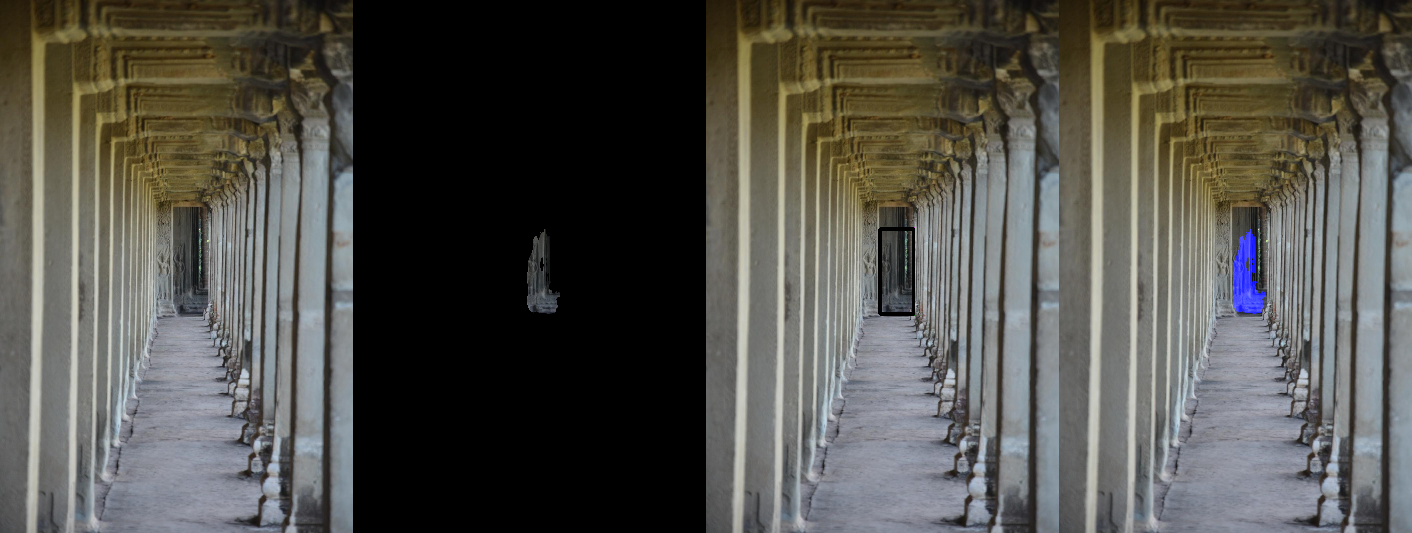

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


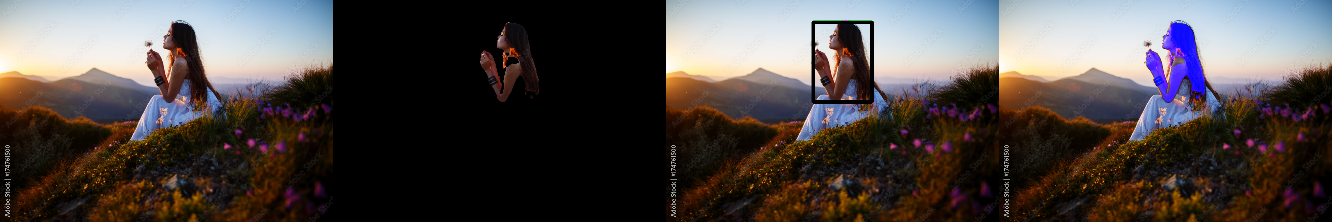

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


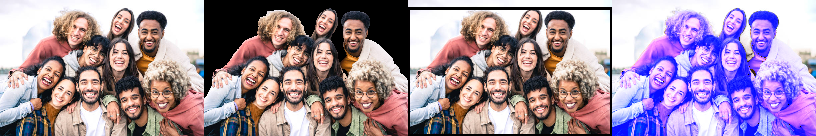

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


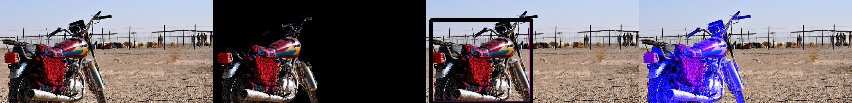

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


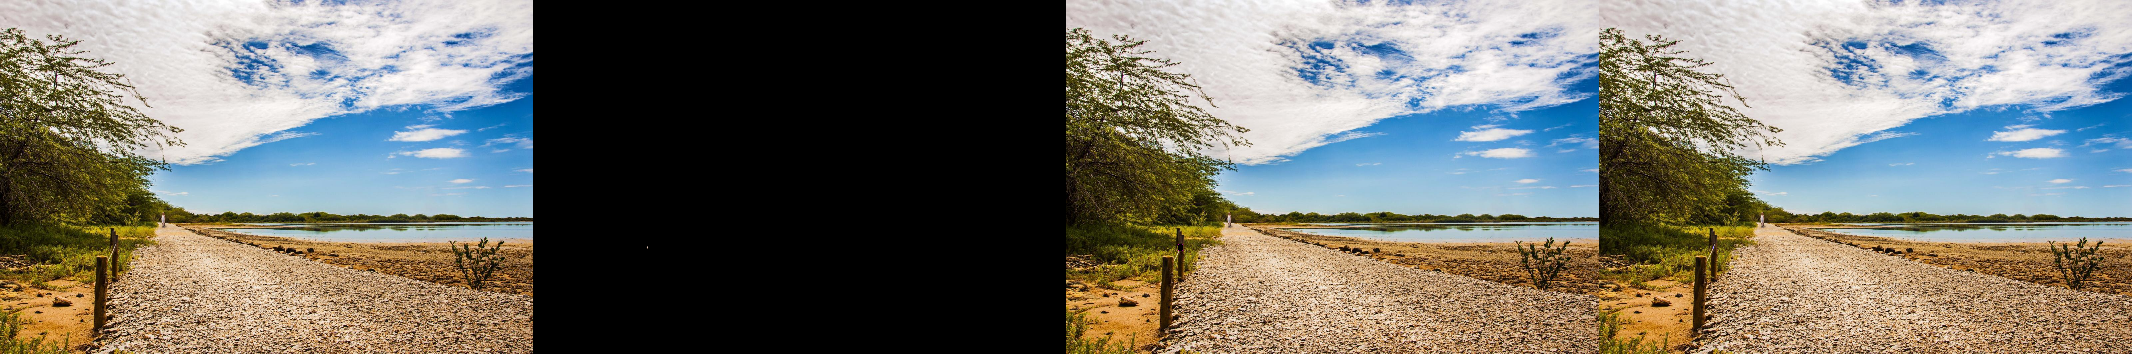

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


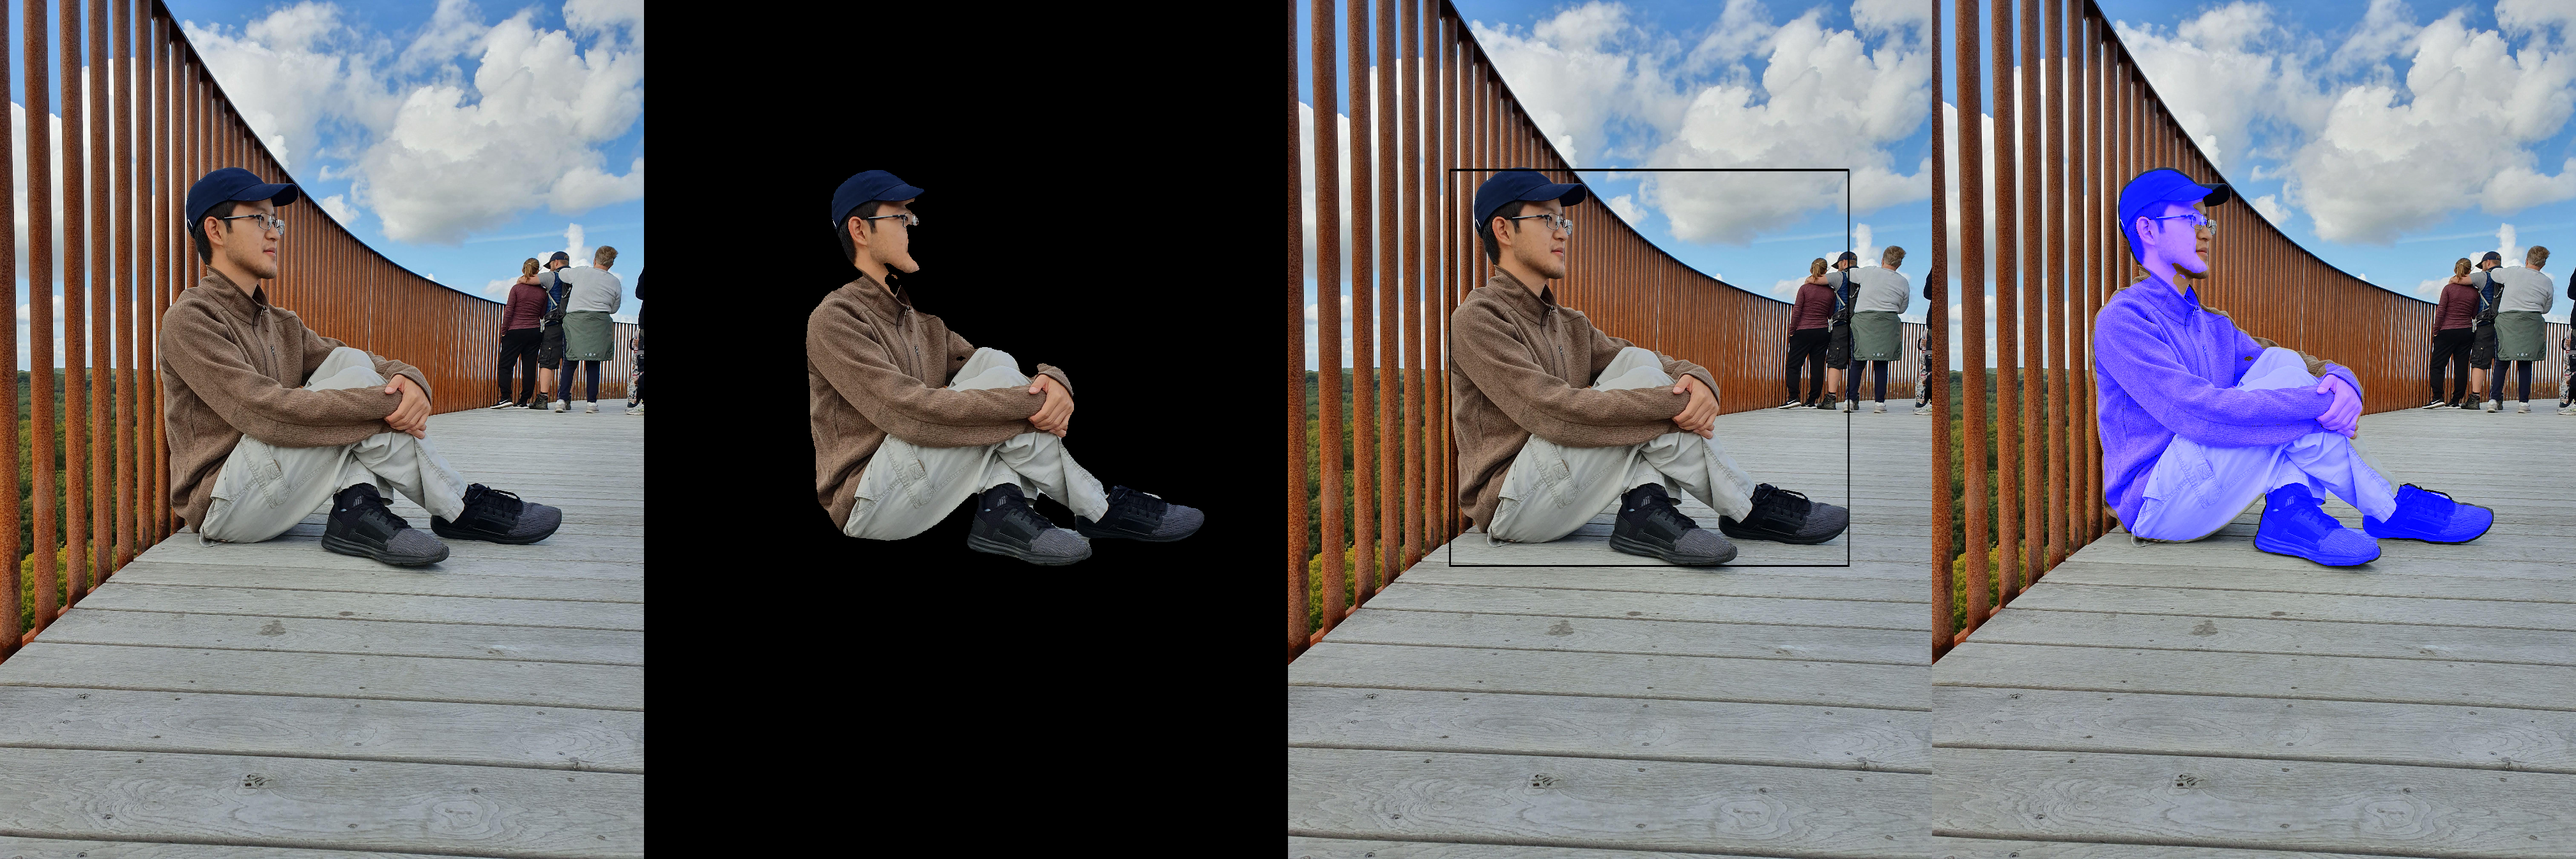

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


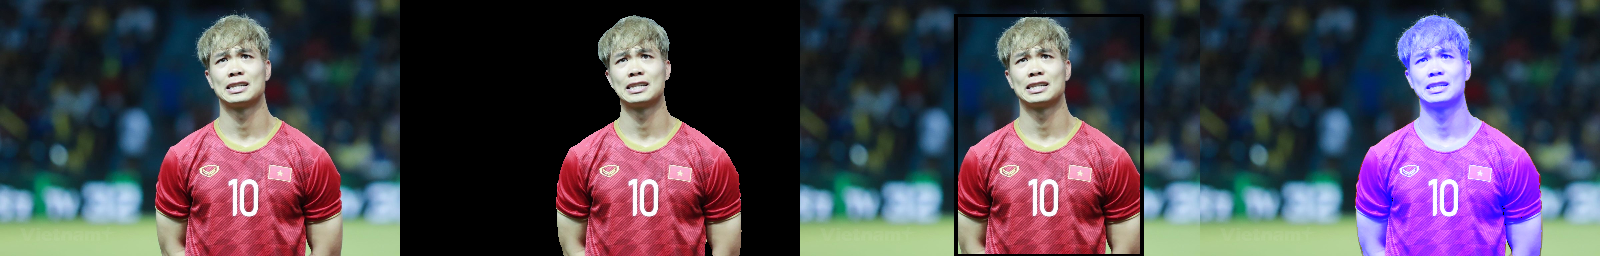

                              INPUT IMAGE                                            BACKGROUND REMOVED                                        BOUNDING BOX                                                     SALIENT MAP


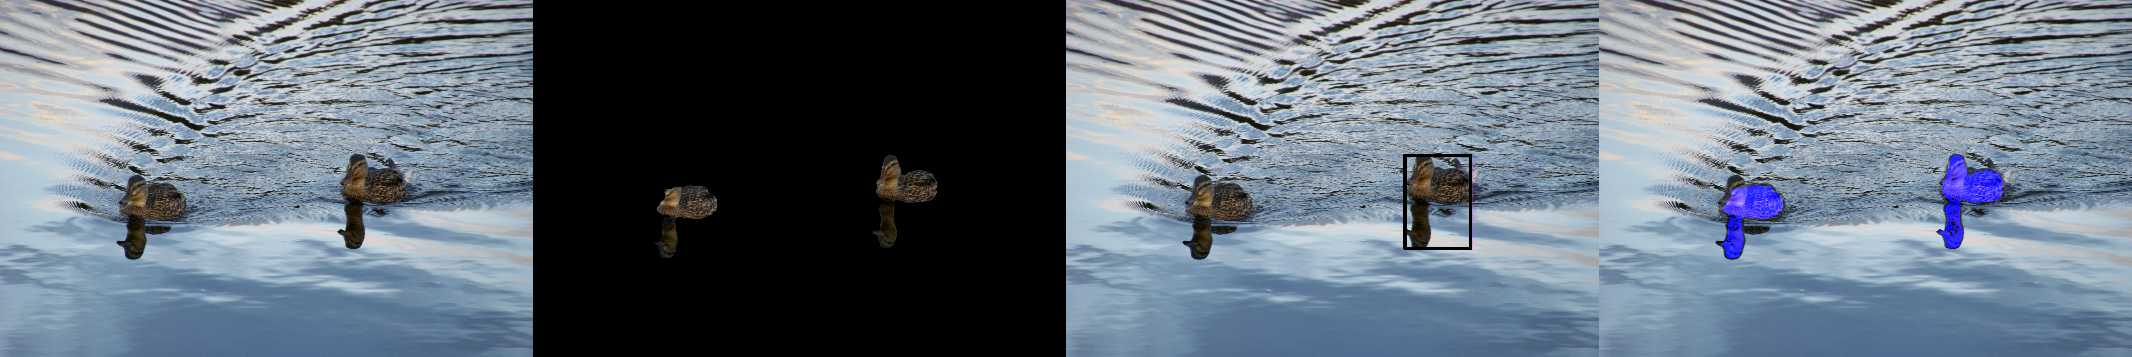

In [37]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn

def save_output(image_name, pred, d_dir):
    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np * 255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1], image.shape[0]), resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1, len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir + imidx + '.png')

class U2NETPredictor:
    def __init__(self, model_name='u2netp', image_dir='images', prediction_dir='preds'):
        self.model_name = model_name
        self.image_dir = image_dir
        self.prediction_dir = os.path.join(os.getcwd(), 'results/')
        self.model_dir = model_name + '.pth'
        self.net = U2NETP(3, 1)
        if torch.cuda.is_available():
            self.net.load_state_dict(torch.load(self.model_dir))
            self.net.cuda()
        else:
            self.net.load_state_dict(torch.load(self.model_dir, map_location=torch.device('cpu')))
        self.net.eval()
        
    def normPRED(self, d):
        ma = torch.max(d)
        mi = torch.min(d)
        dn = (d - mi) / (ma - mi)
        return dn

    def load_model(self):
        model = U2NETP(3, 1)
        if torch.cuda.is_available():
            model.load_state_dict(torch.load(self.model_dir))
            model.cuda()
        else:
            model.load_state_dict(torch.load(self.model_dir, map_location=torch.device('cuda')))
        return model

    def infer_dir(self):
        img_name_list = glob.glob(os.path.join(self.image_dir, '*'))
        
        test_salobj_dataset = SalObjDataset(
            img_name_list=img_name_list,
            lbl_name_list=[],
            transform=transforms.Compose([RescaleT(320), ToTensorLab(flag=0)])
        )
        test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers=1)

        model = self.load_model()
        model.eval()

        for i_test, data_test in enumerate(test_salobj_dataloader):
            print("Inferencing:", img_name_list[i_test].split(os.sep)[-1])

            inputs_test = data_test['image']
            inputs_test = inputs_test.type(torch.FloatTensor)

            if torch.cuda.is_available():
                inputs_test = Variable(inputs_test.cuda())
            else:
                inputs_test = Variable(inputs_test)

            d1, d2, d3, d4, d5, d6, d7 = model(inputs_test)

            pred = d1[:, 0, :, :]
            pred = normPRED(pred)

            if not os.path.exists(self.prediction_dir):
                os.makedirs(self.prediction_dir, exist_ok=True)
            save_output(img_name_list[i_test], pred, self.prediction_dir)

            del d1, d2, d3, d4, d5, d6, d7
            
    def infer_image(self, image_path, output_dir='results/'):
        if not os.path.isabs(image_path):
            image_path = os.path.join(os.getcwd(), image_path)
        image_path = os.path.abspath(image_path)
        image = io.imread(image_path)
        img = transform.resize(image, (320, 320))
        img = img.transpose((2, 0, 1))
        img = img[np.newaxis, :, :, :]
        img = torch.from_numpy(img).type(torch.FloatTensor)

        if torch.cuda.is_available():
            img = Variable(img.cuda())
        else:
            img = Variable(img)

        d1, _, _, _, _, _, _ = self.net(img)
        pred = d1[:, 0, :, :]
        pred = self.normPRED(pred)
        
        output_path = os.path.join(output_dir)
        save_output(image_path, pred, output_path)

class ImageProcessor:
    def __init__(self, threshold=0.9, rescale=255, layer=2, color=(255, 0, 255), thickness=9, sal_shift=100):
        self.threshold = threshold
        self.rescale = rescale
        self.layer = layer
        self.color = color
        self.thickness = thickness
        self.sal_shift = sal_shift

    def load_image(self, image_path):
        image = load_img(image_path)
        return img_to_array(image) / self.rescale

    def threshold_image(self, image):
        image[image > self.threshold] = 1
        image[image <= self.threshold] = 0
        return image

    def create_alpha_layer(self, image):
        shape = image.shape
        a_layer_init = np.ones(shape=(shape[0], shape[1], 1))
        mul_layer = np.expand_dims(image[:, :, 0], axis=2)
        return mul_layer * a_layer_init

    def remove_background(self, input_name):
        if input_name == '.ipynb_checkpo':
            return

        output_img = self.load_image(f'results/{input_name}.png')
        out_img = self.threshold_image(output_img)
        rgba_out = np.append(out_img, self.create_alpha_layer(out_img), axis=2)

        input_img = self.load_image(f'images/{input_name}.jpg')
        rgba_inp = np.append(input_img, self.create_alpha_layer(output_img), axis=2)

        rem_back = (rgba_inp * rgba_out)
        rem_back_scaled = rem_back * self.rescale

        return rem_back_scaled

    def get_bbox(self, input_img, output_img):
        out_layer = output_img[:, :, self.layer]
        contours, _ = cv2.findContours(out_layer.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            start = (x, y)
            end = (x + w, y + h)

            box_img = input_img.copy()
            thickness = 9
            color = (255, 0, 255)
            box_img = cv2.rectangle(box_img, start, end, color, thickness)
            a_layer = np.ones(shape=(box_img.shape[0], box_img.shape[1], 1))
            box_img = np.append(box_img, a_layer, axis=2)
            box_img_scaled = box_img * self.rescale
        else:
            box_img_scaled = input_img

        return box_img_scaled


    def get_salient_map(self, input_img, output_img):
        sal_img = input_img.copy()
        add_layer = output_img.copy()
        add_layer[add_layer == 1] = self.sal_shift / self.rescale
        sal_img[:, :, self.layer] += add_layer[:, :, self.layer]
        sal_img = np.append(sal_img, self.create_alpha_layer(input_img), axis=2)
        sal_img_scaled = sal_img * self.rescale
        sal_img_scaled[sal_img_scaled > self.rescale] = self.rescale

        return sal_img_scaled

    def process_image(self, name):
        if name == '.ipynb_checkpo':
            return

        input_img = self.load_image(f'images/{name}.jpg')

        rem_back_scaled = self.remove_background(name)

        box_img_scaled = self.get_bbox(input_img, rem_back_scaled)

        sal_img_scaled = self.get_salient_map(input_img, rem_back_scaled)

        input_img *= self.rescale
        input_img = np.append(input_img, self.rescale * self.create_alpha_layer(input_img), axis=2)
        input_img = cv2.resize(input_img, (int(input_img.shape[1] / 3), int(input_img.shape[0] / 3)))
        rem_back_scaled = cv2.resize(rem_back_scaled, (int(rem_back_scaled.shape[1] / 3), int(rem_back_scaled.shape[0] / 3)))
        box_img_scaled = cv2.resize(box_img_scaled, (int(box_img_scaled.shape[1] / 3), int(box_img_scaled.shape[0] / 3)))
        sal_img_scaled = cv2.resize(sal_img_scaled, (int(sal_img_scaled.shape[1] / 3), int(sal_img_scaled.shape[0] / 3)))
        result = np.concatenate((input_img, rem_back_scaled, box_img_scaled, sal_img_scaled), axis=1)
        result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
        result_img = result_img.convert('RGB')  # Convert to RGB mode
        result_img.save('output.jpg', 'JPEG')  # Save as JPEG
        header = f'{" ":<30}{"INPUT IMAGE":<55}{"BACKGROUND REMOVED":<58}{"BOUNDING BOX":<65}{"SALIENT MAP"}'
        print(header)
        display(result_img)


predictor = U2NETPredictor()
predictor.infer_dir()
image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
image_processor = ImageProcessor()

for name in names:
    image_processor.process_image(name)